# The One - j_nlp

In [2]:
%pylab inline

import pandas as pd
import pickle as pk
from scipy import sparse as sp

from google.colab import drive
drive.mount('/content/gdrive')

p_df = pd.read_csv('j incident.csv',encoding='ISO-8859-1')
docs = array(p_df['short_description'])

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (55,58,66,71,83,89,123,131,132,134,145,146,166,179,180,188,189,200,211) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
!ls '/content/gdrive/Shareddrives/IST 718 Project'

'718 Final Project.pptx'
 a_cleaned.csv
 a_complete.csv
 a_data_BoolOut.csv
'a_outliers (1).gsheet'
 a_outliers.csv
 a_outliers.gsheet
 a_tasks.csv
 a_ts_access.csv
 a_ts_application.csv
 a_ts_email.csv
 a_ts_general.csv
 a_ts_hardware.csv
 a_ts_software.csv
'cleaning and eda.ipynb'
 closed_by.csv
 comp_j_locations.csv
'Converting Categories to TimeSeries DFs.ipynb'
'Copy of Time Series for subcategories.ipynb'
 EDA_AG.ipynb
 EDA_duration.ipynb
'EDA: Subcategory.ipynb'
 incident1.csv
 incident1.gsheet
 incident.csv
 IST718_Project_locations_all.ipynb
 IST718_Project_locations_us.ipynb
 ist_718_syllabus.pdf
 j_cleaned.csv
 j_cleaned.gsheet
 j_complete.csv
 j_data_BoolOut.csv
 j_incident.gsheet
 j_outliers.csv
'j_tasks .csv'
'j_tasks .gsheet'
 j_ts_access.csv
 j_ts_application.csv
 j_ts_connect.csv
 j_ts_desktop.csv
 j_ts_infrastructure.csv
 j_ts_task.csv
 j_ts_teleconference.csv
 nlp.ipynb
 Project_Proposal_1.docx
'Project Screenshots'
'Project Update.docx'
 Prophet_Forecast_to_Staffing

In [8]:
docs 

array(['\tI have opened laptop refresh for more than 1 month and I have not received any updates.This is the ticket number REQ599157 ',
       "   I can't seem to connect via Pulse anymore with my MAC. This was working just fine yesterday. It is giving me invalid certificate. Are there some instructions I can follow?",
       ' " i" key not working : virtual keyboard works fine', ...,
       '[URGENT] Need to push CRT program again',
       '[URGENT] Teams/Skype not connected to network',
       '\\\\p-uniflow-svl\\canon-sp-svl does not recieve my print jobs'],
      dtype=object)

In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
import warnings
warnings.filterwarnings("ignore") 

from gensim.models import Phrases
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [23]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 10% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.1)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 4524
Number of unique words after removing rare and common words: 883


In [24]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 883
Number of documents: 10048


In [13]:
from gensim.models import LdaModel

In [27]:
# Set training parameters.
num_topics = 25
chunksize = 500 # size of the doc looked at every pass
passes = 25 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', random_state=100,\
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)


CPU times: user 1min 22s, sys: 13.8 ms, total: 1min 22s
Wall time: 1min 22s


In [28]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  -5.6986933748369


In [32]:
import torch

In [62]:
!mkdir -p saved_model
model_save_name = 'j_lda.pt'
path = F"/content/gdrive/Shareddrives/IST 718 Project/{model_save_name}"
model.save('/content/saved_model/j_lda')

In [63]:
# Load libraries
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = path, 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [65]:
import os
import tensorflow as tf
from keras.models import load_model
model = tf.keras.models.load_model('/content/saved_model/j_lda')

OSError: ignored

In [68]:
! {sys.executable} -m pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plot it
j_vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(j_vis)

In [69]:
pyLDAvis.save_html(j_vis, '/content/gdrive/Shareddrives/IST 718 Project/j_pyldavis.html')

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

p_df['tokenz'] = docs

docs1 = p_df['tokenz'].apply(lambda l: l[:int0(len(l)/2)])
docs2 = p_df['tokenz'].apply(lambda l: l[int0(len(l)/2):])

In [71]:
corpus1 = [dictionary.doc2bow(doc) for doc in docs1]
corpus2 = [dictionary.doc2bow(doc) for doc in docs2]

# Using the corpus LDA model tranformation
lda_corpus1 = model[corpus1]
lda_corpus2 = model[corpus2]

In [72]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [array(vals)]
        if kwords:
            keys += [array(vals).argmax()]

    return array(top_dist), keys

In [73]:
top_dist1, _ = get_doc_topic_dist(model, lda_corpus1)
top_dist2, _ = get_doc_topic_dist(model, lda_corpus2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist1, top_dist2)]))

random_pairs = np.random.randint(0, len(p_df['short_description']), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist1[i[0]].reshape(1, -1), top_dist2[i[1]].reshape(1, -1)) for i in random_pairs]))

Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.9445816
Inter similarity: cosine similarity between random parts (lower is better):
0.90578413


In [74]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [75]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

other_issue          0.247
vpn                  0.154
other                0.086
vpn_certificate      0.061
sign_in              0.057
connecting           0.038
password_reset       0.028
sign                 0.024
juniper_issued       0.023
allowed              0.021
Topic 1 |---------------------

and_configure        0.144
pro                  0.109
macbook_pro          0.088
call                 0.083
ip                   0.069
configure            0.069
for_wfh              0.057
cell_phone           0.045
team_meeting         0.043
wfh                  0.035
Topic 2 |---------------------

self_service         0.097
install              0.095
it                   0.059
from                 0.051
service              0.039
can                  0.037
connection           0.037
visio                0.036
his                  0.035
self                 0.033
Topic 3 |---------------------

not_able             0.392
abl

In [76]:
j_top_labels = {0: 'VPN - Certificate', 1: 'Mac - Hardware', 2: 'Application - Install', 3: 'Application - Adobe', 4: 'Mac - VPN', 5: 'Loaner Hardware',
              6: 'Hardware - Ports', 7: 'Image Upgrade', 8: 'VPN - cmdb', 9: 'Bitlocker', 10: 'PC - X1 Carbon', 11: 'Device Setup',
              12: 'VPN - easy', 13: 'New Hire Setup', 14: 'PC Breakfix', 15: 'PC - New Refresh Setup', 16: 'Mobillity Devices',
              17: 'Access - Password', 18: 'Application - Install', 19: 'Application - Meeting', 20: 'VPN - Server', 21: 'Zoom',
              22: 'Malware', 23: 'Onsite Connection', 24: 'Wifi Connection'} 

In [80]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [81]:
stops = set(stopwords.words('english'))

def sd_to_wordlist( sd, remove_stopwords=True ):
    '''
        Function converts text to a sequence of words,
        Returns a list of words.
    '''
    lemmatizer = WordNetLemmatizer()
    # 1. Remove non-letters
    short_description = re.sub("[^a-zA-Z]"," ", sd)
    # 2. Convert words to lower case and split them
    words = short_description.lower().split()
    # 3. Remove stop words
    words = [w for w in words if not w in stops]
    # 4. Remove short words
    words = [t for t in words if len(t) > 2]
    # 5. lemmatizing
    words = [nltk.stem.WordNetLemmatizer().lemmatize(t) for t in words]

    return(words)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',\
                                  tokenizer=sd_to_wordlist, ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(p_df['short_description']).toarray()

In [83]:
top_dist =[]
for d in corpus:
    tmp = {i:0 for i in range(num_topics)}
    tmp.update(dict(model[d]))
    vals = list(OrderedDict(tmp).values())
    top_dist += [array(vals)]

In [84]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names()

In [85]:
top_ws = []
for n in range(len(dtm)):
    inds = int0(argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]
    
    top_ws += [' '.join(tmp)]
    
p_df['Text_Rep'] = pd.DataFrame(top_ws)
p_df['clusters'] = pd.DataFrame(lda_keys)
p_df['clusters'].fillna(10, inplace=True)

cluster_colors = {0: 'brown', 1: 'red', 2: 'tomato', 3: 'sandybrown', 4: 'tan', 5:'gold', 6:'yellow', 7:'yellowgreen', 8:'lawngreen', 9:'green', 10:'mediumseagreen',
                  11: 'aquamarine', 12: 'lightseagreen', 13: 'aqua', 14: 'powderblue', 15: 'deepskyblue', 16:'steelblue', 17:'navy', 18:'mediumslateblue', 19:'indigo', 20:'lightgrey',
                  21: 'grey', 22: 'black', 23: 'magenta', 24: 'pink'}

p_df['colors'] = p_df['clusters'].apply(lambda l: cluster_colors[l])

In [86]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

In [87]:
p_df['X_tsne'] =X_tsne[:, 0]
p_df['Y_tsne'] =X_tsne[:, 1]

In [88]:
from bokeh.plotting import figure, show, output_notebook, save, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

In [90]:
source = ColumnDataSource(dict(
    x=p_df['X_tsne'],
    y=p_df['Y_tsne'],
    color=p_df['colors'],
    label=p_df['clusters'].apply(lambda l: j_top_labels[l]),
#     msize= p_df['marker_size'],
    topic_key= p_df['clusters'],
    title= p_df[u'category'],
    content = p_df['Text_Rep']
))

In [93]:
title = 'J T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,save",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8, size=10)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @topic_key "}
plot_lda.legend.location = "top_left"

show(plot_lda)

In [94]:
#save the plot
save(plot_lda, '{}.html'.format(title))
#plot_lda.save_html(plot_lda, '/content/gdrive/Shareddrives/IST 718 Project/j_tsne.html')

'/content/J T-SNE visualization of topics.html'

In [249]:
!mkdir -p saved_model
model_save_name = 'j_tsne.pt'
path = F"/content/gdrive/Shareddrives/IST 718 Project/{model_save_name}"
model.save('/content/saved_model/j_tsne')

INFO:tensorflow:Assets written to: /content/saved_model/j_tsne/assets


In [ ]:
from sklearn import preprocessing
Encode = preprocessing.LabelEncoder()
p_df['Top_Labels'] = Encode.fit_transform(p_df['clusters'])
p_df

# The One - a_nlp

In [98]:
%pylab inline

import pandas as pd
import pickle as pk
from scipy import sparse as sp

p_df = pd.read_csv('/content/gdrive/Shareddrives/IST 718 Project/a_complete.csv',encoding='ISO-8859-1')
p_df['short_description'] = p_df['short_description'].astype(str)
docs = array(p_df['short_description'])

Populating the interactive namespace from numpy and matplotlib


In [99]:
docs

array(['User need to Install Jet stream Viewer', 'Asset Update',
       '#appstore failure', ..., 'Request a Service',
       'Require temporary administrator password or administrator rights',
       'Request a Service'], dtype=object)

In [100]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
import warnings
warnings.filterwarnings("ignore") 

from gensim.models import Phrases
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [102]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 10% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.1)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 37727
Number of unique words after removing rare and common words: 5406


In [103]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5406
Number of documents: 166504


In [104]:
from gensim.models import LdaModel

In [105]:
# Set training parameters.
num_topics = 25
chunksize = 500 # size of the doc looked at every pass
passes = 25 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', random_state=100,\
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

CPU times: user 26min 28s, sys: 1.33 s, total: 26min 29s
Wall time: 26min 29s


In [106]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -537.7040211413442


In [107]:
!mkdir -p saved_model
model_save_name = 'a_lda.pt'
path = F"/content/gdrive/Shareddrives/IST 718 Project/{model_save_name}"
model.save('/content/saved_model/a_lda')

In [108]:
# Load libraries
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = path, 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [109]:
! {sys.executable} -m pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plot it
#plot it
a_vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(a_vis)

In [111]:
pyLDAvis.save_html(a_vis, '/content/gdrive/Shareddrives/IST 718 Project/a_pyldavis.html')

In [112]:
from sklearn.metrics.pairwise import cosine_similarity

p_df['tokenz'] = docs

docs1 = p_df['tokenz'].apply(lambda l: l[:int0(len(l)/2)])
docs2 = p_df['tokenz'].apply(lambda l: l[int0(len(l)/2):])

In [113]:
corpus1 = [dictionary.doc2bow(doc) for doc in docs1]
corpus2 = [dictionary.doc2bow(doc) for doc in docs2]

# Using the corpus LDA model tranformation
lda_corpus1 = model[corpus1]
lda_corpus2 = model[corpus2]

In [114]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [array(vals)]
        if kwords:
            keys += [array(vals).argmax()]

    return array(top_dist), keys

In [115]:
top_dist1, _ = get_doc_topic_dist(model, lda_corpus1)
top_dist2, _ = get_doc_topic_dist(model, lda_corpus2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist1, top_dist2)]))

random_pairs = np.random.randint(0, len(p_df['short_description']), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist1[i[0]].reshape(1, -1), top_dist2[i[1]].reshape(1, -1)) for i in random_pairs]))

Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.96608573
Inter similarity: cosine similarity between random parts (lower is better):
0.9396487


In [116]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [117]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

aecom_com            0.233
aecom                0.196
com                  0.167
sd                   0.101
looking_for          0.075
if                   0.044
permanent_admin      0.043
looking              0.037
know_if              0.012
restore              0.010
Topic 1 |---------------------

email                0.184
adobe_acrobat        0.179
send                 0.094
acrobat              0.089
receive              0.088
adobe                0.079
pro                  0.061
workday              0.040
folder               0.036
project_folder       0.028
Topic 2 |---------------------

team                 0.175
require              0.169
title                0.075
that                 0.064
no                   0.039
microsoft_team       0.030
microsoft            0.025
wa                   0.022
me                   0.022
a                    0.022
Topic 3 |---------------------

oracle               0.222
res

In [118]:
top_labels = {0: 'Software Center', 1:'Adobe', 2:'Teams', 3:'Password Reset - Oracle',4: 'BreakFix', 5:'Login Access',
              6:'Onsite Hardware', 7:'Share Drive', 8: 'Account Setup', 9:'Browser Connection', 10:'Breakfix', 11:'Admin Rights',
              12:'New Hire Setup', 13:'VPN - Okta', 14:'Conferencing', 15:'App Store', 16:'Application Installation - License', 17: 'Distribution List',
              18:'University', 19:'Shared Mailbox', 20:'Network Drive', 21:'Application Installation', 22:'Docking Station', 23:'VPN', 24:'Phone'}

In [119]:
import re
import nltk
from nltk.corpus import stopwords

In [120]:
stops = set(stopwords.words('english'))

def sd_to_wordlist( sd, remove_stopwords=True ):
    '''
        Function converts text to a sequence of words,
        Returns a list of words.
    '''
    lemmatizer = WordNetLemmatizer()
    # 1. Remove non-letters
    short_description = re.sub("[^a-zA-Z]"," ", sd)
    # 2. Convert words to lower case and split them
    words = short_description.lower().split()
    # 3. Remove stop words
    words = [w for w in words if not w in stops]
    # 4. Remove short words
    words = [t for t in words if len(t) > 2]
    # 5. lemmatizing
    words = [nltk.stem.WordNetLemmatizer().lemmatize(t) for t in words]

    return(words)

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',\
                                  tokenizer=sd_to_wordlist, ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(p_df['short_description']).toarray()

In [122]:
top_dist =[]
for d in corpus:
    tmp = {i:0 for i in range(num_topics)}
    tmp.update(dict(model[d]))
    vals = list(OrderedDict(tmp).values())
    top_dist += [array(vals)]

In [123]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names()

In [124]:
top_ws = []
for n in range(len(dtm)):
    inds = int0(argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]
    
    top_ws += [' '.join(tmp)]
    
p_df['Text_Rep'] = pd.DataFrame(top_ws)
p_df['clusters'] = pd.DataFrame(lda_keys)
p_df['clusters'].fillna(10, inplace=True)

cluster_colors = {0: 'brown', 1: 'red', 2: 'tomato', 3: 'sandybrown', 4: 'tan', 5:'gold', 6:'yellow', 7:'yellowgreen', 8:'lawngreen', 9:'green', 10:'mediumseagreen',
                  11: 'aquamarine', 12: 'lightseagreen', 13: 'aqua', 14: 'powderblue', 15: 'deepskyblue', 16:'steelblue', 17:'navy', 18:'mediumslateblue', 19:'indigo', 20:'lightgrey',
                  21: 'grey', 22: 'black', 23: 'magenta', 24: 'pink'}

p_df['colors'] = p_df['clusters'].apply(lambda l: cluster_colors[l])

In [125]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

In [126]:
p_df['X_tsne'] =X_tsne[:, 0]
p_df['Y_tsne'] =X_tsne[:, 1]

In [127]:
from bokeh.plotting import figure, show, output_notebook, save, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

In [ ]:
list(p_df.columns)

['Unnamed: 0',
 'assignment_group',
 'number',
 'state',
 'priority',
 'short_description',
 'description',
 'comments_and_work_notes',
 'work_notes',
 'close_notes',
 'location',
 'sys_created_on',
 'closed_at',
 'made_sla',
 'u_initial_response_sla_completed',
 'business_duration',
 'calendar_duration',
 'reassignment_count',
 'sys_mod_count',
 'assigned_to',
 'closed_by',
 'cmdb_ci',
 'contact_type',
 'sys_created_by',
 'due_date',
 'escalation',
 'follow_up',
 'sla_due',
 'sys_tags',
 'u_task_number_flag',
 'sys_class_name',
 'time_worked',
 'sys_updated_on',
 'sys_updated_by',
 'upon_approval',
 'upon_reject',
 'urgency',
 'user_input',
 'u_vendor_ticket_number',
 'watch_list',
 'work_end',
 'work_notes_list',
 'work_start',
 'opened_at',
 'sys_domain_path',
 'active',
 'comments',
 'closed_by.average_daily_fte',
 'closed_by.city',
 'activity_due',
 'approval',
 'location.city',
 'additional_assignee_list',
 'approval_set',
 'impact',
 'knowledge',
 'u_reason_to_hold',
 'skills',


In [128]:
source = ColumnDataSource(dict(
    x=p_df['X_tsne'],
    y=p_df['Y_tsne'],
    color=p_df['colors'],
    label=p_df['clusters'].apply(lambda l: top_labels[l]),
#     msize= p_df['marker_size'],
    topic_key= p_df['clusters'],
    title= p_df[u'u_actual_category'],
    content = p_df['Text_Rep']
))

In [138]:
title = 'A T-SNE visualization of topics'

a_plot_lda = figure(plot_width=1000, plot_height=1000,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,save",
                     x_axis_type=None, y_axis_type=None, min_border=1)

a_plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8, size=10)#'msize', )

# hover tools
hover = a_plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @topic_key "}
a_plot_lda.legend.location = "top_left"

show(a_plot_lda)

#save the plot
# save(plot_lda, '{}.html'.format(title))

Output hidden; open in https://colab.research.google.com to view.

In [132]:
#save the plot
save(a_plot_lda, '{}.html'.format(title))

'/content/A T-SNE visualization of topics.html'

In [139]:
!mkdir -p saved_model
model_save_name = 'a_tsne.pt'
path = F"/content/gdrive/Shareddrives/IST 718 Project/{model_save_name}"
model.save('/content/saved_model/a_tsne')

In [142]:
from sklearn import preprocessing
Encode = preprocessing.LabelEncoder()
p_df['Top_Labels'] = Encode.fit_transform(p_df['clusters'])
p_df

,Unnamed: 0,assignment_group,number,state,priority,short_description,description,comments_and_work_notes,work_notes,close_notes,location,sys_created_on,closed_at,made_sla,u_initial_response_sla_completed,business_duration,calendar_duration,reassignment_count,sys_mod_count,assigned_to,closed_by,cmdb_ci,contact_type,sys_created_by,due_date,escalation,follow_up,sla_due,sys_tags,u_task_number_flag,sys_class_name,time_worked,sys_updated_on,sys_updated_by,upon_approval,upon_reject,urgency,user_input,u_vendor_ticket_number,watch_list,...,location.state,location.u_region,u_actual_category,u_actual_subcategory,u_cause,u_cause_code,u_qs_fcresolve,u_misrouted,approval_history,business_service,company,correlation_id,correlation_display,delivery_plan,delivery_task,sys_domain,task_effective_number,expected_start,group_list,opened_by,order,parent,route_reason,service_offering,universal_request,service_offering.category,service_offering.subcategory,cmdb_ci.subcategory,cmdb_ci.category,ref_sc_req_item.u_category,ref_sc_task.sc_catalog,ref_sc_req_item.u_subcategory,ref_sc_req_item.u_choice_5,tokenz,Text_Rep,clusters,colors,X_tsne,Y_tsne,Top_Labels
0,0,I-ACM-SD L1-India,INC1499259,Cancelled,P4 - Low,User need to Install Jet stream Viewer,NaN,10-27-2020 13:29:00 - Rajat Kumar (Additional ...,NaN,NaN,"UKBLF1 - Belfast - The Clarence West Building,...",10/27/2020 12:50,10/27/2020 13:29,True,False,2337,2337,1,1,Rajat Kumar,Rajat Kumar,NaN,Chat,integration.USM_chat,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 13:29,706502,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,...,County Antrim,Europe(EMEA),Software,Software Breakfix,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[user, need, to, install, jet, stream, viewer]",viewer need install user need install,10,mediumseagreen,10.804128,-18.177849,10
1,1,I-ACM-SD L1-India,INC1499248,Cancelled,P3 - Minor,Asset Update,Computer Name - USATLL7BBV433\r\n,10-27-2020 12:44:04 - Akshay Tah (Additional c...,NaN,NaN,USATL1 - Atlanta - 1360 Peachtree St Suite 500,10/27/2020 12:43,10/27/2020 12:44,True,False,136,136,0,1,NaN,Akshay Tah,NaN,Phone,92003742,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:44,92003742,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,...,GA,Southeast(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[asset, update]",update asset zoom going,21,grey,4.468254,-13.020164,21
2,2,I-ACM-SD L1-India,INC1499193,Cancelled,P4 - Low,#appstore failure,NaN,10-27-2020 12:17:01 - Akanksha Dubey (Addition...,NaN,NaN,USPOR01 - Portland - 111 SW Columbia,10/27/2020 12:16,10/27/2020 12:17,True,False,488,488,0,1,NaN,Akanksha Dubey,NaN,Phone,92003746,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:17,92003746,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,...,OR,Pacific(AMER),NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[appstore, failure]",appstore failure going gpvpn,21,grey,6.427355,17.261673,21
3,3,I-ACM-CTS-India,INC1498224,Cancelled,P4 - Low,need assistance turning on bitlocker,Name:Sanjay Kumar\r\nPhone:566539297\r\nEmail ...,10-27-2020 12:22:04 - Kaveri S (Additional com...,10-27-2020 12:21:54 - Kaveri S (Work notes)\nm...,NaN,"SARYD1 - RIYADH - Tawuniya Towers, South Tower...",10/27/2020 0:29,10/27/2020 12:22,True,False,1324,42739,1,12,Kaveri S,Kaveri S,NaN,Phone,92003625,NaN,Normal,NaN,UNKNOWN,NaN,NaN,Incident,0,10/27/2020 12:22,92002594,Proceed to Next Task,Cancel all future Tasks,2 - Medium,NaN,NaN,NaN,...,NaN,Middle East (EMEA),Security,Bitlocker - Break/Fix,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[need, assistance, turning, on, bitlocker, nee...",turning need assistance assistance bitlocker,15,de

In [170]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
vect = CountVectorizer()
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [149]:
x = p_df.short_description
y = p_df.Top_Labels
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)
NB.fit(x_train_dtm,y_train)
y_predict = NB.predict(x_test_dtm)
metrics.accuracy_score(y_test,y_predict)

0.712054965646471

In [151]:
rf = RandomForestClassifier(max_depth=100,max_features=100)
rf.fit(x_train_dtm,y_train)
rf_predict = rf.predict(x_test_dtm)
metrics.accuracy_score(y_test,rf_predict)

0.7627684620189304

In [162]:
cvectorizer = CountVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',\
                                  tokenizer=sd_to_wordlist, ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  )


In [163]:
#cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
train_reviews = cvectorizer.fit_transform(x_train)
#cv_train_reviews=cv.fit_transform(x_train_dtm)
#transformed test reviews
test_reviews=cvectorizer.transform(x_test)

print('BOW_cv_train:',train_reviews.shape)
print('BOW_cv_test:',test_reviews.shape)

BOW_cv_train: (124878, 2243)
BOW_cv_test: (41626, 2243)


In [165]:
#tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
ttrain_reviews=tvectorizer.fit_transform(x_train)
#transformed test reviews
ttest_reviews=tvectorizer.transform(x_test)
print('Tfidf_train:',ttrain_reviews.shape)
print('Tfidf_test:',ttest_reviews.shape)

Tfidf_train: (124878, 2243)
Tfidf_test: (41626, 2243)


In [167]:
#training the model
mnb=MultinomialNB()
#fitting the nb for bag of words
mnb_bow=mnb.fit(train_reviews,y_train)
print(mnb_bow)
#fitting the nb for tfidf features
mnb_tfidf=mnb.fit(ttrain_reviews,y_train)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [168]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(test_reviews)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(ttest_reviews)

In [171]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.745303416134147
mnb_tfidf_score : 0.745303416134147


In [172]:
mnb_bow_report = classification_report(y_test,mnb_bow_predict,target_names = ['0','1','2','3','4','5','6','7','8','9',
                                                                              '10','11','12','13','14','15','16','17','18','19',
                                                                              '20','21','22','23','24'])
print(mnb_bow_report)
mnb_tfidf_report = classification_report(y_test,mnb_tfidf_predict,target_names = ['0','1','2','3','4','5','6','7','8','9',
                                                                              '10','11','12','13','14','15','16','17','18','19',
                                                                              '20','21','22','23','24'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1051
           1       0.69      0.77      0.73       996
           2       0.68      0.57      0.62       570
           3       0.70      0.90      0.79      1520
           4       0.53      0.62      0.57      2297
           5       0.72      0.67      0.70       747
           6       0.62      0.72      0.67      1988
           7       0.95      0.86      0.90      1580
           8       0.71      0.56      0.63       662
           9       0.93      0.74      0.83       618
          10       0.83      0.64      0.73       565
          11       0.80      0.55      0.65       636
          12       0.88      0.84      0.86      2291
          13       0.91      0.94      0.93      1906
          14       0.64      0.65      0.64      1362
          15       0.93      0.76      0.84      2601
          16       0.87      0.66      0.75      1662
          17       0.78    

In [185]:
cm_cv = confusion_matrix(y_test,mnb_bow_predict)
cm_tv = confusion_matrix(y_test,mnb_tfidf_predict)
cm_cv , cm_tv

(array([[ 796,   11,    3,   15,   18,   10,    6,    4,    2,    0,    0,
            3,    7,    9,   21,   19,    0,   18,   20,    5,    5,   51,
            2,   17,    9],
        [   0,  770,    2,    2,   13,   10,   10,    2,    1,    0,    0,
            0,    0,    0,    8,    3,    8,   97,    4,    5,    4,   14,
            0,   15,   28],
        [   2,    4,  324,    5,   35,    1,   17,    3,    1,    0,    0,
            0,    6,    6,   36,    0,    3,   67,    5,    7,    4,   19,
            2,   12,   11],
        [   0,    0,    1, 1364,   11,    2,   10,    0,    1,    6,    1,
            1,    0,    7,    3,    0,    0,   16,    3,    8,    6,   48,
            0,   12,   20],
        [   1,   20,    9,   10, 1427,    5,  100,   13,    9,    2,   16,
            5,   41,    7,   41,   19,   28,  235,   29,    2,   45,  135,
            8,   33,   57],
        [   0,    9,    0,    2,   20,  503,   20,    1,    1,    0,    0,
            1,    2,    1,   13,   

[[ 796   11    3   15   18   10    6    4    2    0    0    3    7    9
    21   19    0   18   20    5    5   51    2   17    9]
 [   0  770    2    2   13   10   10    2    1    0    0    0    0    0
     8    3    8   97    4    5    4   14    0   15   28]
 [   2    4  324    5   35    1   17    3    1    0    0    0    6    6
    36    0    3   67    5    7    4   19    2   12   11]
 [   0    0    1 1364   11    2   10    0    1    6    1    1    0    7
     3    0    0   16    3    8    6   48    0   12   20]
 [   1   20    9   10 1427    5  100   13    9    2   16    5   41    7
    41   19   28  235   29    2   45  135    8   33   57]
 [   0    9    0    2   20  503   20    1    1    0    0    1    2    1
    13    2    2   78    6    1   25   24    1   18   17]
 [   6   12    4    9  119    8 1422    0   10    2   16    7   52    8
    24    3   14  102    7    3   15   51    7   64   23]
 [   0    0    1    1   40    8   11 1356    2    0    0    6    0    0
    18    2    8  

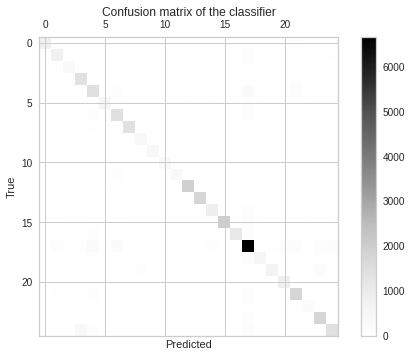

In [188]:
from sklearn.metrics import confusion_matrix
top_labels = {0: 'Software Center', 1:'Adobe', 2:'Teams', 3:'Password Reset - Oracle',4: 'BreakFix', 5:'Login Access',
              6:'Onsite Hardware', 7:'Share Drive', 8: 'Account Setup', 9:'Browser Connection', 10:'Breakfix', 11:'Admin Rights',
              12:'New Hire Setup', 13:'VPN - Okta', 14:'Conferencing', 15:'App Store', 16:'Application Installation - License', 17: 'Distribution List',
              18:'University', 19:'Shared Mailbox', 20:'Network Drive', 21:'Application Installation', 22:'Docking Station', 23:'VPN', 24:'Phone'}
print(cm_cv)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_cv)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

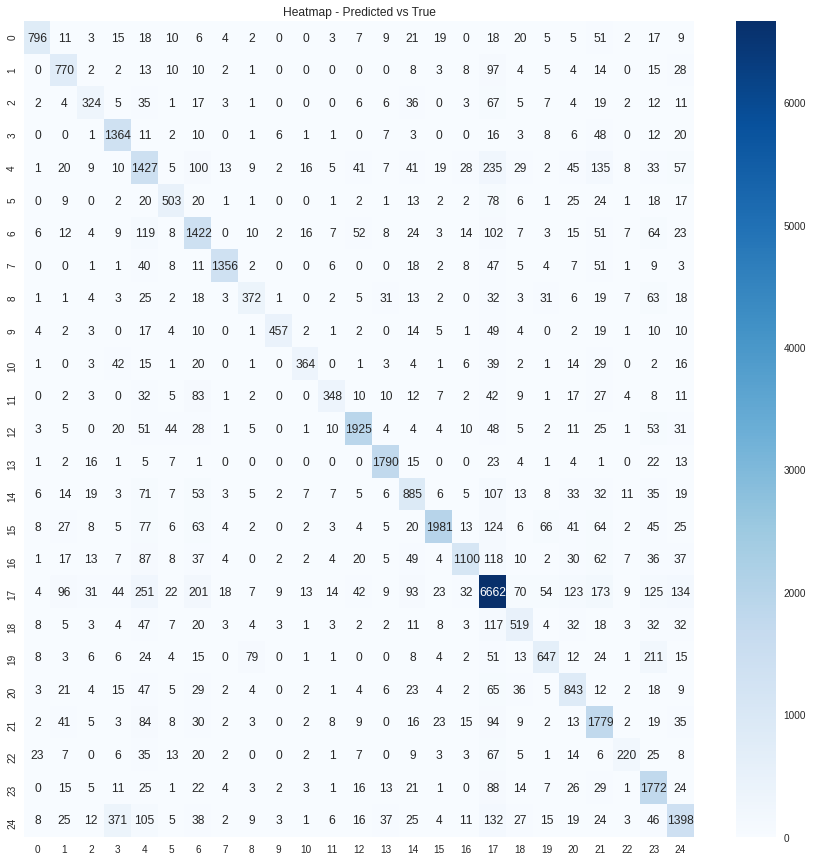

In [246]:
import seaborn as sns
plt.figure(figsize = (15,15))
plt.title('Heatmap - Predicted vs True')
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

In [244]:
x_train = train_reviews.astype('float32')
x_test = test_reviews.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
np.max(x_train)

1.0

In [242]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(Dense(units = 100 , activation = tf.nn.relu,input_dim = x_train.shape[1]))
model.add(Dense(units = 50 , activation = tf.nn.relu))
model.add(Dense(units = 25 , activation = tf.nn.relu))
model.add(Dense(units = 10 , activation = tf.nn.relu))
model.add(Dense(units = 1 , activation = tf.nn.softmax))


model.compile(optimizer = 'adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 100)               224400    
_________________________________________________________________
dense_110 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_111 (Dense)            (None, 25)                1275      
_________________________________________________________________
dense_112 (Dense)            (None, 10)                260       
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 11        
Total params: 230,996
Trainable params: 230,996
Non-trainable params: 0
_________________________________________________________________


In [243]:
model.fit(x_train,y_train , epochs = 25)

Epoch 1/25


InvalidArgumentError: ignored

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])